In [1]:
import sys
from os import listdir
from os.path import isfile, join
import pandas as pd
#!{sys.executable} -m pip install tensorflow-gpu==2.4
#!export LD_LIBRARY_PATH=$LD_LIBRARY_PATH:/home/bhawks/.conda/envs/dune-1dcnn/lib
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras 
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

In [2]:
wireplane = "U"
path = 'processed_data/'
filenames = [path+f for f in listdir(path) if (isfile(join(path, f)) and wireplane in f)]
filenames

['processed_data/mean_U.npy',
 'processed_data/std_U.npy',
 'processed_data/x_test_U.npy',
 'processed_data/x_train_U.npy',
 'processed_data/y_test_AE_U.npy',
 'processed_data/y_test_ROI_U.npy',
 'processed_data/y_train_AE_U.npy',
 'processed_data/y_train_ROI_U.npy']

In [3]:
x_test = np.load(filenames[2])
x_train = np.load(filenames[3])
y_test = np.load(filenames[5])
y_train = np.load(filenames[7])

In [4]:
#split train and valid sets (40k train 10k valid) 
x_train, x_valid, y_train, y_valid = train_test_split(
    x_train, y_train, test_size=0.2, shuffle=True
)

In [5]:
mean = x_train.mean()
std = x_train.std()

In [6]:
x_train_scaled = (x_train-mean)/std
x_valid_scaled = (x_valid-mean)/std
x_test_scaled = (x_test-mean)/std

In [7]:
np.save("latest_models/mean_"+wireplane+"_nu", mean)
np.save("latest_models/scale_"+wireplane+"_nu", std)

In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D, \
    Dropout, Dense,Flatten, AveragePooling1D, BatchNormalization

In [9]:
time_periods = 200
def create_model():
  model = Sequential()  
  #first convolutional block
  model.add(Conv1D(filters=16, kernel_size=3, strides=2, activation = "relu", input_shape=(time_periods,1)))
  model.add(MaxPooling1D(pool_size=2))

  #second convolutional block
  model.add(Conv1D(filters=32, kernel_size=5, strides=2, activation = "relu"))
  model.add(MaxPooling1D(pool_size=2))
  model.add(Dropout(0.1))
  
  #forth convolutional block                                      
  model.add(Conv1D(filters=64, kernel_size=9, activation = "relu"))
  model.add(GlobalMaxPooling1D())
  model.add(Dropout(0.2)) 
    
  model.add(Flatten())

  
 
  model.add(Dense(1, activation="sigmoid", name="wavrec_out"))
  return model

In [10]:
model = create_model()

#lr=0.001
adam = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

model.compile(optimizer = adam, loss = 'binary_crossentropy', metrics = ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 99, 16)            64        
                                                                 
 max_pooling1d (MaxPooling1D  (None, 49, 16)           0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 23, 32)            2592      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 11, 32)           0         
 1D)                                                             
                                                                 
 dropout (Dropout)           (None, 11, 32)            0         
                                                                 
 conv1d_2 (Conv1D)           (None, 3, 64)             1

In [11]:
x_train_scaled = x_train_scaled.reshape(x_train_scaled.shape[0], x_train_scaled.shape[1], 1)
x_valid_scaled = x_valid_scaled.reshape(x_valid_scaled.shape[0], x_valid_scaled.shape[1], 1)
x_test_scaled = x_test_scaled.reshape(x_test_scaled.shape[0], x_test_scaled.shape[1], 1)

In [12]:
print(x_train_scaled.shape, x_valid_scaled.shape, x_test_scaled.shape)

(52902, 200, 1) (13226, 200, 1) (66129, 200, 1)


In [13]:
earlystop = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=5,
    verbose=0,
    mode="auto",
    baseline=None,
    restore_best_weights=True,
)

In [14]:
%%time
history = model.fit(x_train_scaled,                                                              
                    y_train,                                                            
                    batch_size=2048,                                              
                    epochs=100,      
                    
                   # epochs=30, 
                    #epochs = 6,
                    callbacks=[earlystop],
                     # callbacks=callbacks_list,                         
                    validation_data=(x_valid_scaled, y_valid),                                               
                    verbose=1)   

Epoch 1/100
26/26 [==============================] - 9s 29ms/step - loss: 0.4711 - accuracy: 0.8441 - val_loss: 0.2340 - val_accuracy: 0.9306
Epoch 2/100
26/26 [==============================] - 0s 12ms/step - loss: 0.1821 - accuracy: 0.9464 - val_loss: 0.1353 - val_accuracy: 0.9579
Epoch 3/100
26/26 [==============================] - 0s 12ms/step - loss: 0.1346 - accuracy: 0.9620 - val_loss: 0.1178 - val_accuracy: 0.9657
Epoch 4/100
26/26 [==============================] - 0s 13ms/step - loss: 0.1239 - accuracy: 0.9657 - val_loss: 0.1130 - val_accuracy: 0.9664
Epoch 5/100
26/26 [==============================] - 0s 13ms/step - loss: 0.1184 - accuracy: 0.9675 - val_loss: 0.1080 - val_accuracy: 0.9690
Epoch 6/100
26/26 [==============================] - 0s 13ms/step - loss: 0.1162 - accuracy: 0.9686 - val_loss: 0.1048 - val_accuracy: 0.9701
Epoch 7/100
26/26 [==============================] - 0s 10ms/step - loss: 0.1130 - accuracy: 0.9699 - val_loss: 0.1023 - val_accuracy: 0.9710
Epoch 

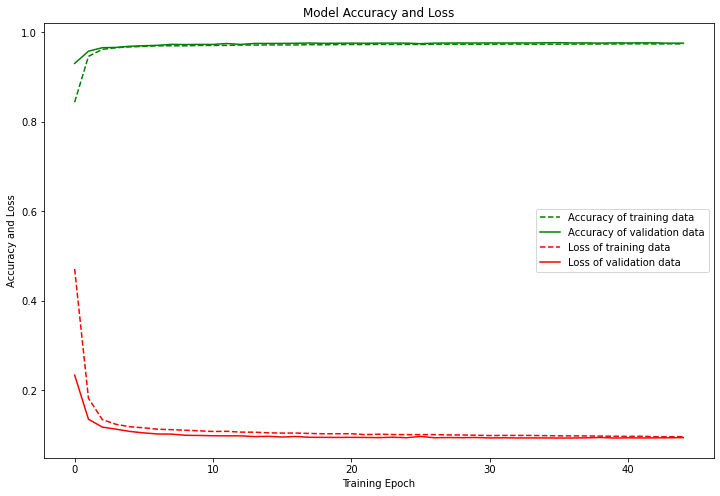

In [15]:
plt.figure(figsize=(12, 8))                                                     
plt.plot(history.history['accuracy'], "g--", label="Accuracy of training data", antialiased=True)
plt.plot(history.history['val_accuracy'], "g", label="Accuracy of validation data", antialiased=True)
plt.plot(history.history['loss'], "r--", label="Loss of training data", antialiased=True)
plt.plot(history.history['val_loss'], "r", label="Loss of validation data", antialiased=True)
plt.title('Model Accuracy and Loss')                                            
plt.ylabel('Accuracy and Loss')                                                 
plt.xlabel('Training Epoch')                                                    
#plt.ylim(0)                                                                     
plt.legend()                                                                    
plt.show()     

In [16]:
#del x_train

import gc
gc.collect()

5081

In [17]:
model.save("latest_models/model_" + wireplane + "plane_nu.h5")

In [18]:
model.evaluate(x_test_scaled, y_test, batch_size=4096)

17/17 [==============================] - 0s 8ms/step - loss: 0.0967 - accuracy: 0.9742


[0.09666625410318375, 0.9742321968078613]

In [19]:
x_train_ = x_train_scaled
y_train_ = y_train

x_valid_ = x_valid_scaled
y_valid_ = y_valid


# Train

In [20]:
%%time
%matplotlib inline
import seaborn as sns
infer = model.predict(x_train_, batch_size=1024)

52/52 [==============================] - 0s 2ms/step
Wall time: 921 ms


<AxesSubplot:>

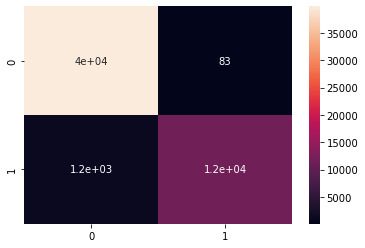

In [21]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_train_, infer>0.5)
sns.heatmap(cm, annot=True)

<AxesSubplot:>

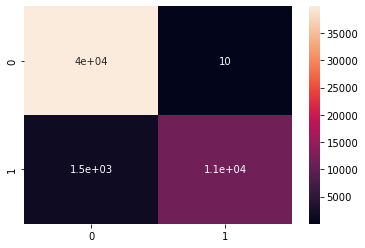

In [22]:
cm2 = confusion_matrix(y_train_, infer>0.9)
sns.heatmap(cm2, annot=True)

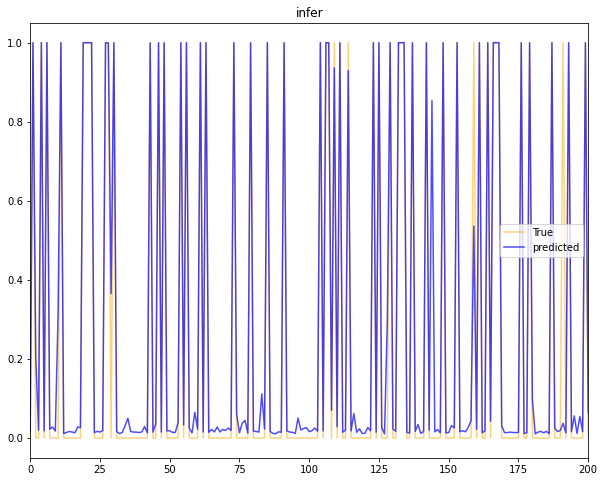

In [23]:
start_for_plot = 0
fig = plt.figure(figsize=(10, 8))
plt.plot(y_train,color='orange',alpha=0.5, label='True')
plt.plot(infer,color='blue',alpha=0.7, label='predicted')
plt.xlim(start_for_plot, start_for_plot + 200)
plt.title("infer")
plt.legend()
plt.show()

In [24]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_train_, infer)
auc_keras = auc(fpr_keras, tpr_keras)

In [25]:
print(auc_keras)

0.9786770413887629


In [26]:
np.save("latest_results/false_positive_" + wireplane + "_train", fpr_keras)
np.save("latest_results/true_positive_" + wireplane + "_train", tpr_keras)
np.save("latest_results/thresholds_" + wireplane + "_train", thresholds_keras)

# Valid

In [27]:
%%time
infer = model.predict(x_valid_, batch_size=4096)

4/4 [==============================] - 0s 59ms/step
Wall time: 361 ms


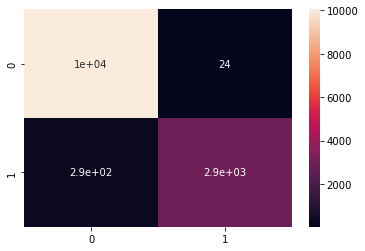

In [28]:
cmv = confusion_matrix(y_valid_, infer>0.5)
sns.heatmap(cmv, annot=True)
plt.show()

<AxesSubplot:>

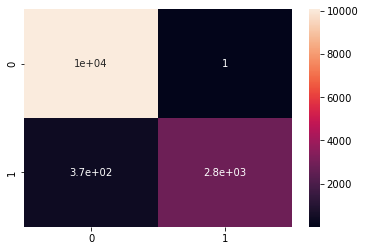

In [29]:
cmv2 = confusion_matrix(y_valid_, infer>0.9)
sns.heatmap(cmv2, annot=True)

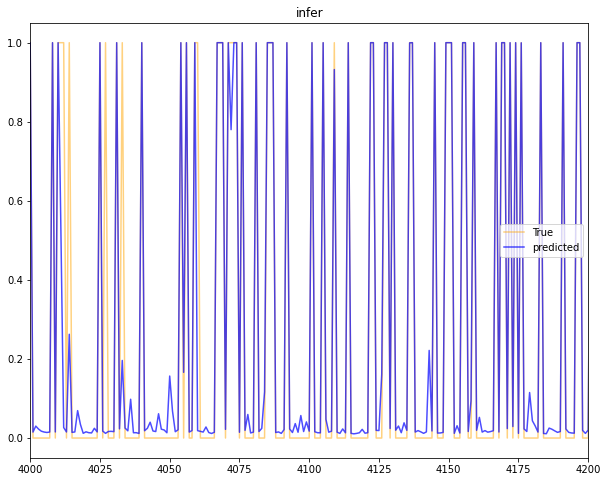

In [30]:
start_for_plot = 4000
fig = plt.figure(figsize=(10, 8))
plt.plot(y_valid_,color='orange',alpha=0.5, label='True')
plt.plot(infer,color='blue',alpha=0.7, label='predicted')
plt.xlim(start_for_plot, start_for_plot + 200)
plt.title("infer")
plt.legend()
plt.show()

In [31]:
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_valid_, infer)
auc_keras = auc(fpr_keras, tpr_keras)
print(auc_keras)

0.974563114690925


In [32]:
np.save("latest_results/false_positive_" + wireplane + "_valid", fpr_keras)
np.save("latest_results/true_positive_" + wireplane + "_valid", tpr_keras)
np.save("latest_results/thresholds_" + wireplane + "_valid", thresholds_keras)

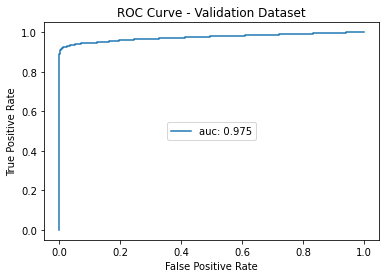

In [33]:
plt.plot(fpr_keras, tpr_keras, label='auc: ' + str(round(auc_keras,3)))
plt.title("ROC Curve - Validation Dataset")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc='center')
plt.show()

# test

In [34]:
#%%time
all_infer = model.predict(x_test_scaled, batch_size=4096)
all_y_test = y_test


17/17 [==============================] - 0s 8ms/step


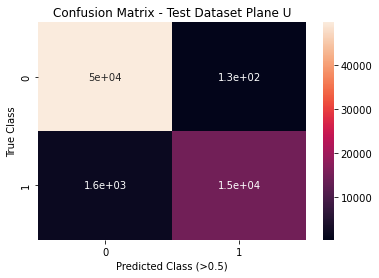

In [35]:
all1 = confusion_matrix(all_y_test, all_infer>0.5)
sns.heatmap(all1, annot=True)
plt.title("Confusion Matrix - Test Dataset Plane " + wireplane)
plt.xlabel("Predicted Class (>0.5)")
plt.ylabel("True Class")
plt.show()

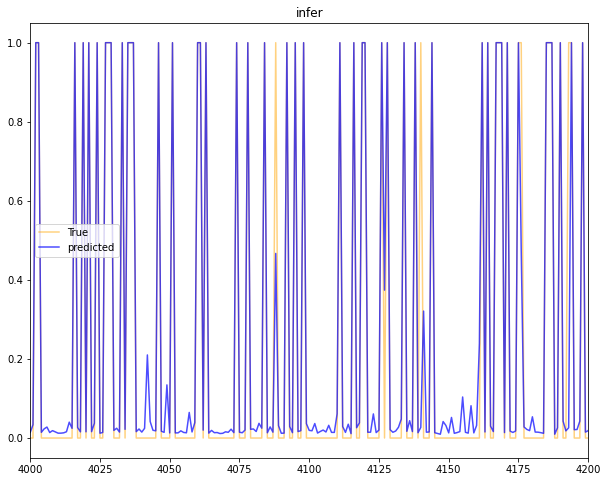

In [36]:
start_for_plot = 4000
fig = plt.figure(figsize=(10, 8))
plt.plot(all_y_test,color='orange',alpha=0.5, label='True')
plt.plot(all_infer,color='blue',alpha=0.7, label='predicted')
plt.xlim(start_for_plot, start_for_plot + 200)
plt.title("infer")
plt.legend()
plt.show()

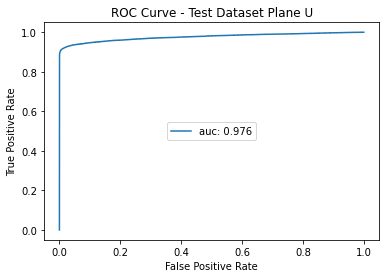

In [37]:
fpr_keras, tpr_keras, thresholds_keras = roc_curve(all_y_test, all_infer)
plt.plot(fpr_keras, tpr_keras, label='auc: ' + str(round(auc(fpr_keras, tpr_keras), 3)))
plt.title("ROC Curve - Test Dataset Plane " + wireplane )
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc='center')
plt.show()

In [38]:
%%time
#cc_infer_signal = model.predict(cc_x_test_scaled[cc_y_test==1], batch_size=4096)
#cc_infer_noise = model.predict(cc_x_test_scaled[cc_y_test==0], batch_size=4096)
#es_infer_signal = model.predict(es_x_test_scaled[es_y_test==1], batch_size=4096)
#es_infer_noise = model.predict(es_x_test_scaled[es_y_test==0], batch_size=4096)
all_infer_signal = model.predict(x_test_scaled[y_test==1], batch_size=4096)
all_infer_noise = model.predict(x_test_scaled[y_test==0], batch_size=4096)

13/13 [==============================] - 0s 20ms/step
Wall time: 774 ms


(array([4.5474e+04, 2.7260e+03, 7.7500e+02, 3.2700e+02, 2.0900e+02,
        1.4300e+02, 9.4000e+01, 6.0000e+01, 2.9000e+01, 3.0000e+01,
        3.3000e+01, 1.5000e+01, 1.6000e+01, 2.2000e+01, 8.0000e+00,
        1.1000e+01, 1.0000e+01, 5.0000e+00, 7.0000e+00, 6.0000e+00]),
 array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
        0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ],
       dtype=float32),
 <BarContainer object of 20 artists>)

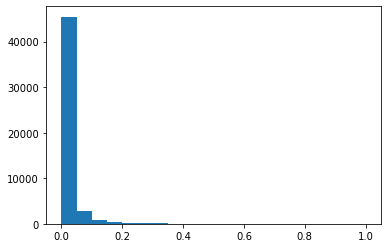

In [39]:
plt.hist(all_infer_noise, range = (0,1), bins=20)

(array([  885.,   215.,   121.,    78.,    54.,    61.,    44.,    40.,
           41.,    32.,    27.,    41.,    37.,    37.,    43.,    40.,
           68.,    67.,    97., 14101.]),
 array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
        0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ],
       dtype=float32),
 <BarContainer object of 20 artists>)

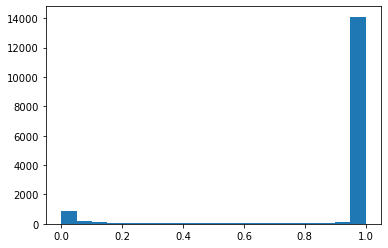

In [40]:
plt.hist(all_infer_signal, range = (0,1), bins=20)